# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups   
Sample_162  Q5VYB9;Q86VZ4       16.371
Sample_048  O00391              17.997
Sample_152  A0A087WTA8;P08123   17.181
Sample_077  A2NJV5              21.708
Sample_019  P12273              14.148
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups                                     
Sample_116  E7EPS8;P28827;P28827-2                                11.959
Sample_080  Q9H6X2;Q9H6X2-2;Q9H6X2-3;Q9H6X2-4;Q9H6X2-5;Q9H6X2-6   14.736
Sample_000  F2Z2C8;Q9BVH7                                         13.276
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.916
            A0A075B6Q5                 12.608
            A0A075B6R2                 12.632
            A0A075B6S5                 12.763
            A0A087WSY4                 13.340
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   14.315
            Q9UI40;Q9UI40-2            12.848
            Q9UIW2                     11.384
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.411
            Q9UP79                     12.997
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.350,15.050,16.842,19.863,15.942,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.517,19.067,...,15.528,15.576,14.411,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.859,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.711,17.705,17.039,15.529,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.279,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.940,15.345,17.084,18.708,14.249,19.433,12.178,10.985
Sample_207,15.739,16.877,15.469,16.898,14.154,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,13.916,...,16.012,15.178,13.563,15.050,16.842,19.863,12.485,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.833,19.067,16.188,...,15.528,15.576,11.895,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.822,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.000,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.671,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.435,15.345,17.084,18.708,14.249,19.433,13.161,13.755
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 371.05it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

100%|██████████| 2/2 [00:00<00:00,  5.80it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.82it/s]

100%|██████████| 3/3 [00:00<00:00,  4.69it/s]

100%|██████████| 3/3 [00:00<00:00,  4.98it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.55it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.31it/s]

100%|██████████| 4/4 [00:00<00:00,  4.61it/s]

100%|██████████| 4/4 [00:00<00:00,  5.00it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.29it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.02it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.55it/s]

100%|██████████| 5/5 [00:01<00:00,  3.34it/s]

100%|██████████| 5/5 [00:01<00:00,  3.61it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 10.69it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  6.61it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  6.23it/s]

100%|██████████| 6/6 [00:00<00:00,  5.82it/s]

100%|██████████| 6/6 [00:00<00:00,  6.30it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.73it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.34it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.66it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.45it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.30it/s]

100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

100%|██████████| 7/7 [00:01<00:00,  4.55it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.78it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.51it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.69it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.46it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.24it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.19it/s]

100%|██████████| 8/8 [00:01<00:00,  4.24it/s]

100%|██████████| 8/8 [00:01<00:00,  4.54it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  9.58it/s]

 33%|███▎      | 3/9 [00:00<00:00,  7.31it/s]

 44%|████▍     | 4/9 [00:00<00:00,  6.24it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  5.87it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  5.72it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  5.43it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  5.28it/s]

100%|██████████| 9/9 [00:01<00:00,  5.21it/s]

100%|██████████| 9/9 [00:01<00:00,  5.74it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 12.80it/s]

 40%|████      | 4/10 [00:00<00:00,  7.34it/s]

 50%|█████     | 5/10 [00:00<00:00,  6.57it/s]

 60%|██████    | 6/10 [00:00<00:00,  6.16it/s]

 70%|███████   | 7/10 [00:01<00:00,  5.87it/s]

 80%|████████  | 8/10 [00:01<00:00,  5.16it/s]

 90%|█████████ | 9/10 [00:01<00:00,  5.17it/s]

100%|██████████| 10/10 [00:01<00:00,  5.13it/s]

100%|██████████| 10/10 [00:01<00:00,  5.83it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 12.84it/s]

 36%|███▋      | 4/11 [00:00<00:00,  8.02it/s]

 45%|████▌     | 5/11 [00:00<00:00,  7.42it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  7.08it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  6.95it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  6.83it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  6.75it/s]

 91%|█████████ | 10/11 [00:01<00:00,  6.71it/s]

100%|██████████| 11/11 [00:01<00:00,  6.60it/s]

100%|██████████| 11/11 [00:01<00:00,  7.10it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 12.80it/s]

 33%|███▎      | 4/12 [00:00<00:00,  8.39it/s]

 42%|████▏     | 5/12 [00:00<00:00,  7.62it/s]

 50%|█████     | 6/12 [00:00<00:00,  7.17it/s]

 58%|█████▊    | 7/12 [00:00<00:00,  6.92it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  6.73it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  6.60it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  6.53it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  6.55it/s]

100%|██████████| 12/12 [00:01<00:00,  6.50it/s]

100%|██████████| 12/12 [00:01<00:00,  7.02it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 12.85it/s]

 31%|███       | 4/13 [00:00<00:01,  8.06it/s]

 38%|███▊      | 5/13 [00:00<00:01,  7.45it/s]

 46%|████▌     | 6/13 [00:00<00:00,  7.09it/s]

 54%|█████▍    | 7/13 [00:00<00:00,  6.86it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  6.72it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  6.63it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  6.55it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  6.49it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  6.47it/s]

100%|██████████| 13/13 [00:01<00:00,  6.44it/s]

100%|██████████| 13/13 [00:01<00:00,  6.92it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 12.83it/s]

 29%|██▊       | 4/14 [00:00<00:01,  7.97it/s]

 36%|███▌      | 5/14 [00:00<00:01,  7.42it/s]

 43%|████▎     | 6/14 [00:00<00:01,  7.06it/s]

 50%|█████     | 7/14 [00:00<00:01,  6.93it/s]

 57%|█████▋    | 8/14 [00:01<00:00,  6.75it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  6.64it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  6.66it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  6.42it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  6.40it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  6.40it/s]

100%|██████████| 14/14 [00:02<00:00,  6.40it/s]

100%|██████████| 14/14 [00:02<00:00,  6.86it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 12.60it/s]

 27%|██▋       | 4/15 [00:00<00:01,  8.03it/s]

 33%|███▎      | 5/15 [00:00<00:01,  7.46it/s]

 40%|████      | 6/15 [00:00<00:01,  7.09it/s]

 47%|████▋     | 7/15 [00:00<00:01,  6.88it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  6.75it/s]

 60%|██████    | 9/15 [00:01<00:00,  6.72it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  6.61it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  6.62it/s]

 80%|████████  | 12/15 [00:01<00:00,  6.53it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  6.44it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  6.40it/s]

100%|██████████| 15/15 [00:02<00:00,  6.40it/s]

100%|██████████| 15/15 [00:02<00:00,  6.86it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.049 0.010          0.735 0.369       0.110   
2             0.003 0.001      0.048 0.015          0.755 0.097       0.619   
3             0.004 0.003      0.048 0.009          0.739 0.099       0.623   
4             0.003 0.001      0.031 0.005          0.775 0.086       0.724   
5             0.004 0.000      0.045 0.004          0.802 0.090       0.775   
6             0.003 0.001      0.032 0.013          0.791 0.093       0.762   
7             0.003 0.001      0.036 0.008          0.790 0.094       0.753   
8             0.002 0.000      0.029 0.005          0.827 0.089       0.812   
9             0.002 0.000      0.027 0.004          0.818 0.078       0.805   
10            0.002 0.000      0.028 0.004          0.805 0.076       0.836   
11            0.002 0.000      0.027 0.000          0.799 0.080       0.833   
12            0.002 0.000      0.027 0.000          0.799 0.083       0.830   
13            0.002 0.000      0.027 0.000          0.803 0.084       0.831   
14            0.003 0.000      0.027 0.001          0.791 0.083       0.805   
15            0.002 0.000      0.027 0.001          0.787 0.078       0.804   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.086   0.184 0.130                  0.547 0.041        0.854   
2          0.111   0.675 0.087                  0.735 0.062        0.800   
3          0.114   0.669 0.085                  0.729 0.061        0.795   
4          0.112   0.745 0.087                  0.785 0.069        0.866   
5          0.115   0.784 0.088                  0.817 0.072        0.868   
6          0.117   0.772 0.090                  0.807 0.073        0.865   
7          0.123   0.767 0.094                  0.803 0.076        0.864   
8          0.098   0.815 0.075                  0.841 0.065        0.891   
9          0.104   0.808 0.074                  0.836 0.063        0.891   
10         0.099   0.817 0.073                  0.844 0.064        0.907   
11         0.098   0.813 0.073                  0.839 0.063        0.905   
12         0.101   0.811 0.075                  0.838 0.065        0.904   
13         0.103   0.813 0.074                  0.840 0.063        0.903   
14         0.099   0.795 0.073                  0.824 0.062        0.905   
15         0.100   0.792 0.073                  0.822 0.062        0.903   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.069                  0.826 0.093        210.000 0.000  
2          0.070                  0.777 0.088        210.000 0.000  
3          0.073                  0.772 0.088        210.000 0.000  
4          0.061                  0.851 0.070        210.000 0.000  
5          0.067                  0.863 0.068        210.000 0.000  
6          0.067                  0.859 0.070        210.000 0.000  
7          0.067                  0.857 0.070        210.000 0.000  
8          0.062                  0.882 0.070        210.000 0.000  
9          0.062                  0.884 0.066        210.000 0.000  
10         0.052                  0.899 0.054        210.000 0.000  
11         0.054                  0.896 0.056        210.000 0.000  
12         0.054                  0.894 0.057        210.000 0.000  
13         0.054                  0.892 0.058        210.000 0.000  
14         0.052                  0.890 0.059        210.000 0.000  
15         0.052                  0.888 0.058 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 553.41it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 11.36it/s]

100%|██████████| 2/2 [00:00<00:00, 11.31it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 11.29it/s]

100%|██████████| 3/3 [00:00<00:00,  8.48it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.30it/s]

100%|██████████| 4/4 [00:00<00:00,  7.12it/s]

100%|██████████| 4/4 [00:00<00:00,  7.53it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 11.35it/s]

 80%|████████  | 4/5 [00:00<00:00,  7.16it/s]

100%|██████████| 5/5 [00:00<00:00,  6.61it/s]

100%|██████████| 5/5 [00:00<00:00,  7.07it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 11.32it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  7.02it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  6.53it/s]

100%|██████████| 6/6 [00:00<00:00,  6.19it/s]

100%|██████████| 6/6 [00:00<00:00,  6.68it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 11.32it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  7.07it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  6.53it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  6.23it/s]

100%|██████████| 7/7 [00:01<00:00,  6.00it/s]

100%|██████████| 7/7 [00:01<00:00,  6.51it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 11.35it/s]

 50%|█████     | 4/8 [00:00<00:00,  7.10it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  6.60it/s]

 75%|███████▌  | 6/8 [00:00<00:00,  6.25it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  6.04it/s]

100%|██████████| 8/8 [00:01<00:00,  5.93it/s]

100%|██████████| 8/8 [00:01<00:00,  6.43it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 11.42it/s]

 44%|████▍     | 4/9 [00:00<00:00,  7.10it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  6.54it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  6.22it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  6.00it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  5.87it/s]

100%|██████████| 9/9 [00:01<00:00,  5.76it/s]

100%|██████████| 9/9 [00:01<00:00,  6.28it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 10.59it/s]

 40%|████      | 4/10 [00:00<00:00,  6.98it/s]

 50%|█████     | 5/10 [00:00<00:00,  6.54it/s]

 60%|██████    | 6/10 [00:00<00:00,  6.28it/s]

 70%|███████   | 7/10 [00:01<00:00,  6.09it/s]

 80%|████████  | 8/10 [00:01<00:00,  5.92it/s]

 90%|█████████ | 9/10 [00:01<00:00,  5.77it/s]

100%|██████████| 10/10 [00:01<00:00,  5.34it/s]

100%|██████████| 10/10 [00:01<00:00,  6.05it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 11.34it/s]

 36%|███▋      | 4/11 [00:00<00:00,  7.09it/s]

 45%|████▌     | 5/11 [00:00<00:00,  6.60it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  6.24it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  6.01it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  5.87it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  5.75it/s]

 91%|█████████ | 10/11 [00:01<00:00,  5.72it/s]

100%|██████████| 11/11 [00:01<00:00,  5.63it/s]

100%|██████████| 11/11 [00:01<00:00,  6.13it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 11.22it/s]

 33%|███▎      | 4/12 [00:00<00:01,  6.99it/s]

 42%|████▏     | 5/12 [00:00<00:01,  6.48it/s]

 50%|█████     | 6/12 [00:00<00:00,  6.22it/s]

 58%|█████▊    | 7/12 [00:01<00:00,  6.01it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  5.88it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  5.77it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  5.75it/s]

 92%|█████████▏| 11/12 [00:01<00:00,  5.72it/s]

100%|██████████| 12/12 [00:01<00:00,  5.70it/s]

100%|██████████| 12/12 [00:01<00:00,  6.10it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 11.27it/s]

 31%|███       | 4/13 [00:00<00:01,  6.96it/s]

 38%|███▊      | 5/13 [00:00<00:01,  6.51it/s]

 46%|████▌     | 6/13 [00:00<00:01,  6.23it/s]

 54%|█████▍    | 7/13 [00:01<00:00,  6.01it/s]

 62%|██████▏   | 8/13 [00:01<00:00,  5.87it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  5.75it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  5.72it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  5.71it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  5.70it/s]

100%|██████████| 13/13 [00:02<00:00,  5.69it/s]

100%|██████████| 13/13 [00:02<00:00,  6.06it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01, 11.34it/s]

 29%|██▊       | 4/14 [00:00<00:01,  7.03it/s]

 36%|███▌      | 5/14 [00:00<00:01,  6.58it/s]

 43%|████▎     | 6/14 [00:00<00:01,  6.28it/s]

 50%|█████     | 7/14 [00:01<00:01,  5.98it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  5.83it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  5.75it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  5.74it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  5.66it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  5.69it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  5.63it/s]

100%|██████████| 14/14 [00:02<00:00,  5.61it/s]

100%|██████████| 14/14 [00:02<00:00,  6.01it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01, 11.39it/s]

 27%|██▋       | 4/15 [00:00<00:01,  7.19it/s]

 33%|███▎      | 5/15 [00:00<00:01,  6.61it/s]

 40%|████      | 6/15 [00:00<00:01,  6.27it/s]

 47%|████▋     | 7/15 [00:01<00:01,  6.08it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  5.94it/s]

 60%|██████    | 9/15 [00:01<00:01,  5.86it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  5.78it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  5.72it/s]

 80%|████████  | 12/15 [00:01<00:00,  5.65it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  5.67it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  5.66it/s]

100%|██████████| 15/15 [00:02<00:00,  5.69it/s]

100%|██████████| 15/15 [00:02<00:00,  6.05it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.027 0.000          0.107 0.279       0.011   
2             0.002 0.000      0.027 0.000          0.714 0.098       0.645   
3             0.002 0.000      0.027 0.000          0.823 0.094       0.708   
4             0.002 0.000      0.027 0.000          0.801 0.090       0.719   
5             0.002 0.000      0.027 0.000          0.801 0.093       0.717   
6             0.002 0.000      0.027 0.002          0.831 0.089       0.776   
7             0.002 0.000      0.027 0.000          0.862 0.077       0.814   
8             0.002 0.000      0.027 0.000          0.859 0.078       0.814   
9             0.002 0.000      0.027 0.000          0.858 0.079       0.811   
10            0.002 0.000      0.027 0.000          0.863 0.075       0.818   
11            0.002 0.000      0.027 0.000          0.859 0.079       0.814   
12            0.002 0.000      0.027 0.000          0.848 0.083       0.812   
13            0.002 0.000      0.027 0.000          0.852 0.075       0.818   
14            0.002 0.000      0.027 0.000          0.849 0.078       0.814   
15            0.002 0.000      0.027 0.000          0.851 0.077       0.807   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.028   0.019 0.050                  0.501 0.013        0.871   
2          0.106   0.672 0.084                  0.725 0.067        0.799   
3          0.108   0.756 0.084                  0.797 0.063        0.878   
4          0.119   0.752 0.084                  0.793 0.065        0.890   
5          0.117   0.750 0.083                  0.791 0.064        0.891   
6          0.098   0.798 0.075                  0.829 0.061        0.919   
7          0.105   0.833 0.072                  0.858 0.059        0.926   
8          0.105   0.831 0.072                  0.857 0.059        0.925   
9          0.110   0.828 0.075                  0.855 0.061        0.922   
10         0.098   0.836 0.068                  0.861 0.056        0.923   
11         0.101   0.832 0.071                  0.857 0.059        0.921   
12         0.114   0.824 0.077                  0.851 0.063        0.927   
13         0.107   0.830 0.073                  0.856 0.060        0.932   
14         0.108   0.827 0.072                  0.853 0.059        0.933   
15         0.113   0.824 0.079                  0.851 0.064        0.931   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.836 0.087        210.000 0.000  
2          0.079                  0.754 0.101        210.000 0.000  
3          0.063                  0.842 0.086        210.000 0.000  
4          0.056                  0.858 0.077        210.000 0.000  
5          0.053                  0.860 0.068        210.000 0.000  
6          0.043                  0.904 0.051        210.000 0.000  
7          0.043                  0.911 0.052        210.000 0.000  
8          0.043                  0.909 0.052        210.000 0.000  
9          0.044                  0.905 0.055        210.000 0.000  
10         0.042                  0.906 0.052        210.000 0.000  
11         0.043                  0.904 0.053        210.000 0.000  
12         0.041                  0.906 0.052        210.000 0.000  
13         0.038                  0.916 0.046        210.000 0.000  
14         0.038                  0.915 0.049        210.000 0.000  
15         0.038                  0.913 0.047 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1029.53it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 54.95it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 41.07it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 35.62it/s]

100%|██████████| 4/4 [00:00<00:00, 35.39it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 80%|████████  | 4/5 [00:00<00:00, 37.78it/s]

100%|██████████| 5/5 [00:00<00:00, 35.14it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 31.99it/s]

100%|██████████| 6/6 [00:00<00:00, 29.81it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 36.59it/s]

100%|██████████| 7/7 [00:00<00:00, 31.82it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 50%|█████     | 4/8 [00:00<00:00, 37.06it/s]

100%|██████████| 8/8 [00:00<00:00, 30.87it/s]

100%|██████████| 8/8 [00:00<00:00, 31.58it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 44%|████▍     | 4/9 [00:00<00:00, 37.61it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 30.78it/s]

100%|██████████| 9/9 [00:00<00:00, 30.73it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 40%|████      | 4/10 [00:00<00:00, 36.25it/s]

 80%|████████  | 8/10 [00:00<00:00, 30.20it/s]

100%|██████████| 10/10 [00:00<00:00, 29.93it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 36%|███▋      | 4/11 [00:00<00:00, 34.88it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 28.30it/s]

100%|██████████| 11/11 [00:00<00:00, 26.94it/s]

100%|██████████| 11/11 [00:00<00:00, 27.82it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 33%|███▎      | 4/12 [00:00<00:00, 35.41it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 28.48it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 27.01it/s]

100%|██████████| 12/12 [00:00<00:00, 27.74it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 31%|███       | 4/13 [00:00<00:00, 34.65it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 28.30it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 26.94it/s]

100%|██████████| 13/13 [00:00<00:00, 27.35it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 29%|██▊       | 4/14 [00:00<00:00, 35.42it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 29.08it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 27.64it/s]

100%|██████████| 14/14 [00:00<00:00, 27.47it/s]

100%|██████████| 14/14 [00:00<00:00, 28.23it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 27%|██▋       | 4/15 [00:00<00:00, 34.24it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 29.62it/s]

 80%|████████  | 12/15 [00:00<00:00, 28.65it/s]

100%|██████████| 15/15 [00:00<00:00, 27.75it/s]

100%|██████████| 15/15 [00:00<00:00, 28.55it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.027 0.001          0.000 0.000       0.000   
2             0.002 0.000      0.027 0.000          0.682 0.103       0.604   
3             0.002 0.000      0.027 0.001          0.708 0.106       0.619   
4             0.002 0.000      0.027 0.000          0.782 0.087       0.682   
5             0.002 0.000      0.027 0.000          0.804 0.085       0.696   
6             0.002 0.000      0.027 0.000          0.797 0.082       0.712   
7             0.002 0.000      0.027 0.000          0.789 0.079       0.713   
8             0.002 0.000      0.027 0.000          0.782 0.082       0.706   
9             0.002 0.000      0.027 0.000          0.776 0.083       0.695   
10            0.002 0.000      0.027 0.000          0.769 0.078       0.699   
11            0.002 0.000      0.027 0.000          0.764 0.079       0.675   
12            0.002 0.000      0.027 0.000          0.768 0.080       0.684   
13            0.002 0.000      0.027 0.000          0.761 0.079       0.687   
14            0.002 0.000      0.027 0.000          0.743 0.081       0.707   
15            0.002 0.000      0.027 0.000          0.739 0.076       0.701   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.766   
2          0.120   0.634 0.094                  0.697 0.072        0.789   
3          0.125   0.654 0.100                  0.714 0.074        0.801   
4          0.123   0.721 0.088                  0.770 0.062        0.853   
5          0.117   0.738 0.081                  0.784 0.059        0.857   
6          0.108   0.745 0.073                  0.787 0.055        0.852   
7          0.107   0.743 0.072                  0.785 0.054        0.850   
8          0.112   0.735 0.076                  0.779 0.057        0.844   
9          0.112   0.726 0.074                  0.771 0.055        0.842   
10         0.118   0.725 0.075                  0.771 0.056        0.843   
11         0.122   0.708 0.081                  0.759 0.057        0.842   
12         0.132   0.714 0.088                  0.764 0.062        0.841   
13         0.137   0.712 0.091                  0.762 0.064        0.843   
14         0.130   0.717 0.088                  0.762 0.067        0.850   
15         0.126   0.712 0.083                  0.758 0.063        0.848   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.712 0.075        210.000 0.000  
2          0.061                  0.734 0.083        210.000 0.000  
3          0.061                  0.759 0.074        210.000 0.000  
4          0.056                  0.810 0.069        210.000 0.000  
5          0.048                  0.803 0.071        210.000 0.000  
6          0.050                  0.799 0.074        210.000 0.000  
7          0.050                  0.798 0.071        210.000 0.000  
8          0.051                  0.791 0.074        210.000 0.000  
9          0.050                  0.788 0.072        210.000 0.000  
10         0.048                  0.788 0.073        210.000 0.000  
11         0.049                  0.784 0.073        210.000 0.000  
12         0.050                  0.786 0.073        210.000 0.000  
13         0.051                  0.792 0.073        210.000 0.000  
14         0.052                  0.800 0.070        210.000 0.000  
15         0.052                  0.797 0.071 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,3,15,15
score_time,1,6,1
test_precision,8,10,5
test_recall,10,13,7
test_f1,10,10,6
test_balanced_accuracy,10,10,6
test_roc_auc,10,14,5
test_average_precision,10,13,4
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01, 11.34it/s]

 29%|██▊       | 4/14 [00:00<00:01,  7.09it/s]

 36%|███▌      | 5/14 [00:00<00:01,  6.56it/s]

 43%|████▎     | 6/14 [00:00<00:01,  6.27it/s]

 50%|█████     | 7/14 [00:01<00:01,  6.04it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  5.93it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  5.91it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  5.82it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  5.77it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  5.74it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  5.68it/s]

100%|██████████| 14/14 [00:02<00:00,  5.65it/s]

100%|██████████| 14/14 [00:02<00:00,  6.07it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 80%|████████  | 4/5 [00:00<00:00, 37.94it/s]

100%|██████████| 5/5 [00:00<00:00, 34.54it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 12.77it/s]

 40%|████      | 4/10 [00:00<00:00,  8.25it/s]

 50%|█████     | 5/10 [00:00<00:00,  7.19it/s]

 60%|██████    | 6/10 [00:00<00:00,  6.93it/s]

 70%|███████   | 7/10 [00:00<00:00,  6.76it/s]

 80%|████████  | 8/10 [00:01<00:00,  6.66it/s]

 90%|█████████ | 9/10 [00:01<00:00,  6.65it/s]

100%|██████████| 10/10 [00:01<00:00,  6.70it/s]

100%|██████████| 10/10 [00:01<00:00,  7.10it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


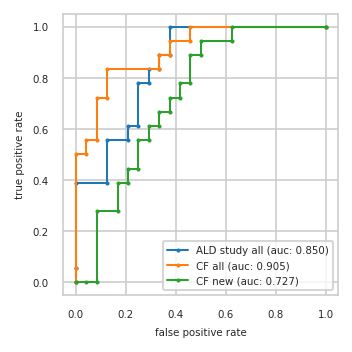

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.042 0.000
2          0.000 0.389  0.000 0.500  0.083 0.000
3          0.125 0.389  0.042 0.500  0.083 0.278
4          0.125 0.556  0.042 0.556  0.167 0.278
5          0.208 0.556  0.083 0.556  0.167 0.389
6          0.208 0.611  0.083 0.722  0.208 0.389
7          0.250 0.611  0.125 0.722  0.208 0.444
8          0.250 0.778  0.125 0.833  0.250 0.444
9          0.292 0.778  0.333 0.833  0.250 0.556
10         0.292 0.833  0.333 0.889  0.292 0.556
11         0.333 0.833  0.375 0.889  0.292 0.611
12         0.333 0.889  0.375 0.944  0.333 0.611
13         0.375 0.889  0.458 0.944  0.333 0.667
14         0.375 1.000  0.458 1.000  0.375 0.667
15         1.000 1.000  1.000 1.000  0.375 0.722
16           NaN   NaN    NaN   NaN  0.417 0.722
17           NaN   NaN    NaN   NaN  0.417 0.778
18           NaN   NaN    NaN   NaN  0.458 0.778
19           NaN   NaN    NaN   NaN  0.458 0.889
20           NaN   NaN    NaN   NaN  0.500 0.889
21           NaN   NaN    NaN   NaN  0.500 0.944
22           NaN   NaN    NaN   NaN  0.625 0.944
23           NaN   NaN    NaN   NaN  0.625 1.000
24           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,B0QYF8;P02144,P22676,Q96MU8;Q96MU8-2;Q96MU8-3
2,G3XAP6;P49747;P49747-2,A6NNI4;G8JLH6;P21926,P51688
3,P02766,Q14894,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
4,P61981,Q9Y2T3;Q9Y2T3-3,A0A0J9YW36;Q9NZ72;Q9NZ72-2
5,P04075,P61981,None
6,P14174,P14174,None
7,Q9Y2T3;Q9Y2T3-3,P04075,None
8,P00338;P00338-3,P63104,None


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


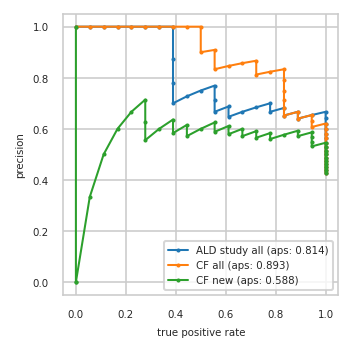

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.529 1.000
9          0.545 1.000     0.545 1.000     0.545 1.000
10         0.562 1.000     0.562 1.000     0.531 0.944
11         0.581 1.000     0.581 1.000     0.548 0.944
12         0.600 1.000     0.600 1.000     0.567 0.944
13         0.621 1.000     0.621 1.000     0.586 0.944
14         0.643 1.000     0.607 0.944     0.571 0.889
15         0.667 1.000     0.630 0.944     0.593 0.889
16         0.654 0.944     0.654 0.944     0.577 0.833
17         0.640 0.889     0.640 0.889     0.560 0.778
18         0.667 0.889     0.667 0.889     0.583 0.778
19         0.652 0.833     0.652 0.833     0.565 0.722
20         0.682 0.833     0.682 0.833     0.591 0.722
21         0.667 0.778     0.714 0.833     0.571 0.667
22         0.700 0.778     0.750 0.833     0.600 0.667
23         0.684 0.722     0.789 0.833     0.579 0.611
24         0.667 0.667     0.833 0.833     0.611 0.611
25         0.647 0.611     0.824 0.778     0.588 0.556
26         0.688 0.611     0.812 0.722     0.625 0.556
27         0.667 0.556     0.867 0.722     0.600 0.500
28         0.714 0.556     0.857 0.667     0.571 0.444
29         0.769 0.556     0.846 0.611     0.615 0.444
30         0.750 0.500     0.833 0.556     0.583 0.389
31         0.727 0.444     0.909 0.556     0.636 0.389
32         0.700 0.389     0.900 0.500     0.600 0.333
33         0.778 0.389     1.000 0.500     0.556 0.278
34         0.875 0.389     1.000 0.444     0.625 0.278
35         1.000 0.389     1.000 0.389     0.714 0.278
36         1.000 0.333     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


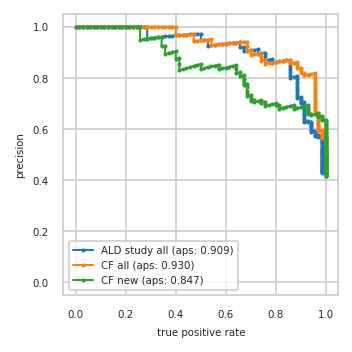

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


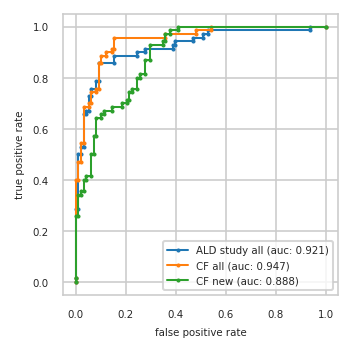

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}